In [20]:
# --- 1. Library Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # Added for saving/loading the model

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve, auc


In [3]:
from imblearn.over_sampling import SMOTE 
from imblearn.pipeline import Pipeline as ImbPipeline 


In [4]:
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

In [5]:
# --- 2. Data Loading and Merging ---
# NOTE: If you run this in an environment where the files are available, 
# uncomment the loading lines below. Otherwise, the synthetic data will be generated.
try:
    # 1. Attempt to load the standard single file
    df = pd.read_csv('creditcard.csv')
    print("Data loaded successfully from 'creditcard.csv'.")
    print(f"Dataset shape: {df.shape}")

except FileNotFoundError:
    print("Error: 'creditcard.csv' not found. Checking for separate fraud/valid files.")
    
    # 2. Alternative: Load and merge separate fraud and valid files
    try:
        # Assuming your files have the same columns as the full dataset
        fraud_df = pd.read_csv('fraud_values.csv')
        valid_df = pd.read_csv('valid_values.csv')
        
        # Rename 'class' column to 'Class' for consistency if necessary
        if 'class' in fraud_df.columns:
            fraud_df.rename(columns={'class': 'Class'}, inplace=True)
            valid_df.rename(columns={'class': 'Class'}, inplace=True)
            
        df = pd.concat([valid_df, fraud_df], ignore_index=True)
        print("Data merged successfully from 'fraud_values.csv' and 'valid_values.csv'.")
        print(f"Merged Dataset shape: {df.shape}")

    except FileNotFoundError:
        # 3. Fallback: Generate synthetic data
        print("Separate files not found. Generating a simple synthetic DataFrame for demonstration purposes.")
        
        N_SAMPLES = 10000
        N_FRAUD = 150
        np.random.seed(42)

        data = {
            f'V{i}': np.random.normal(loc=0, scale=1, size=N_SAMPLES) for i in range(1, 29)
        }
        data['Time'] = np.random.randint(1, 172792, size=N_SAMPLES)
        data['Amount'] = np.random.lognormal(mean=3, sigma=1, size=N_SAMPLES)
        df = pd.DataFrame(data)

        # Inject fraud 
        fraud_indices = np.random.choice(N_SAMPLES, N_FRAUD, replace=False)
        df.loc[fraud_indices, 'Class'] = 1
        df.loc[df['Class'].isnull(), 'Class'] = 0 
        df['Class'] = df['Class'].astype(int)

        # Adjust fraud transaction amounts to be higher
        df.loc[df['Class'] == 1, 'Amount'] = np.random.lognormal(mean=5, sigma=0.5, size=N_FRAUD)
        print("Synthetic data generated.")
        




Data loaded successfully from 'creditcard.csv'.
Dataset shape: (284807, 31)


--- Initial Class Distribution (Full Dataset) ---
Class
0    284315
1       492
Name: count, dtype: int64
Fraud Rate: 0.1727%


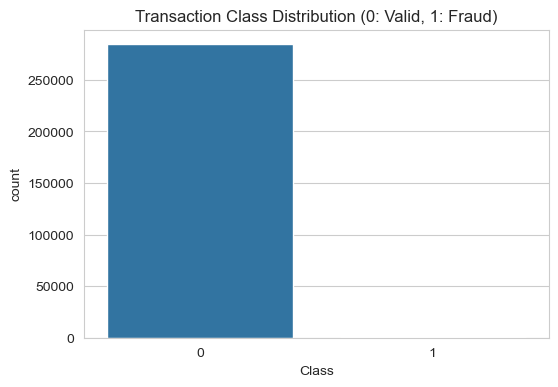

In [6]:
# Check Class Distribution (Imbalance)
print("--- Initial Class Distribution (Full Dataset) ---")
print(df['Class'].value_counts())
print(f"Fraud Rate: {df['Class'].value_counts()[1] / df.shape[0] * 100:.4f}%")

# Plot 1: Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=df)
plt.title('Transaction Class Distribution (0: Valid, 1: Fraud)')
plt.show()

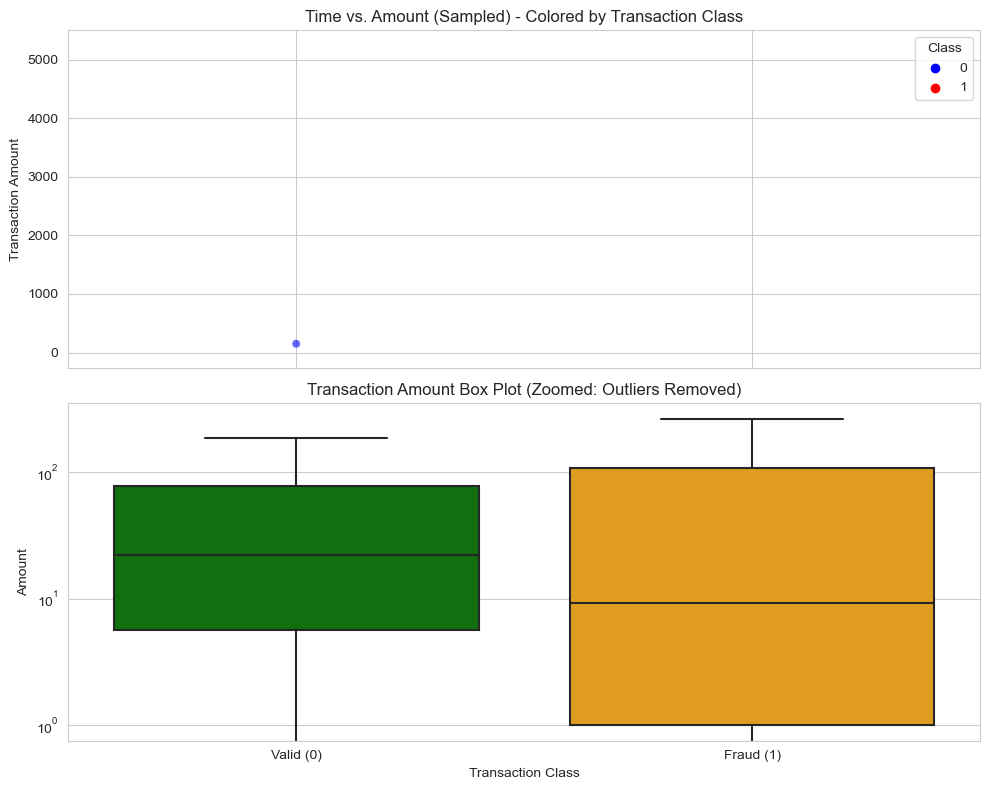

In [7]:
# Plot 2: Transaction Amount Distribution by Class (CRITICAL VISUALIZATION)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Scatter plot of Time vs Amount, colored by Class
sns.scatterplot(x='Time', y='Amount', hue='Class', data=df.sample(frac=0.1, random_state=42), 
                alpha=0.6, palette={0: 'blue', 1: 'red'}, ax=ax1)
ax1.set_title('Time vs. Amount (Sampled) - Colored by Transaction Class')
ax1.set_ylabel('Transaction Amount')

# Box plots for Amount comparison
sns.boxplot(x='Class', y='Amount', data=df, showfliers=False, ax=ax2, 
            palette={0: 'green', 1: 'orange'})
ax2.set_title('Transaction Amount Box Plot (Zoomed: Outliers Removed)')
ax2.set_xticklabels(['Valid (0)', 'Fraud (1)'])
ax2.set_xlabel('Transaction Class')
ax2.set_yscale('log') # Use log scale for better comparison

plt.tight_layout()
plt.show()

In [8]:
df['Normalized_Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df = df.drop(['Time', 'Amount'], axis=1)
print("Features scaled and original columns removed.")

Features scaled and original columns removed.


In [9]:
 # Define features (X) and target (y)
X = df.drop('Class', axis=1)
y = df['Class']

# Split data: Stratify ensures the same proportion of fraud cases in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"X_train shape: {X_train.shape}, Fraud in train: {y_train.sum()}")
print(f"X_test shape: {X_test.shape}, Fraud in test: {y_test.sum()}")

print("\n" + "-"*60 + "\n") # Cell Separator
###



X_train shape: (199364, 29), Fraud in train: 344
X_test shape: (85443, 29), Fraud in test: 148

------------------------------------------------------------



In [10]:
# %% [python]
# Apply SMOTE only to the training data to balance the classes
print("\nApplying SMOTE to training data...")
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print(f"Resampled X_train shape: {X_train_res.shape}")
print(f"Resampled y_train fraud count: {y_train_res.sum()}") # Should now be balanced




Applying SMOTE to training data...
Resampled X_train shape: (398040, 29)
Resampled y_train fraud count: 199020


--- Class Distribution After SMOTE (Training Data) ---


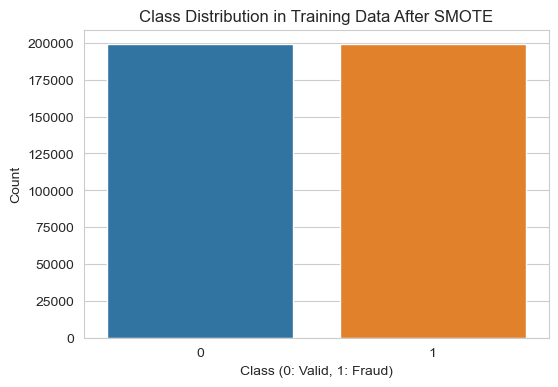

The classes are now balanced for model training.

------------------------------------------------------------



In [11]:
print("--- Class Distribution After SMOTE (Training Data) ---")

# Convert resampled y to a Series for easier plotting
y_train_res_series = pd.Series(y_train_res, name='Class')

plt.figure(figsize=(6, 4))
sns.countplot(x=y_train_res_series)
plt.title('Class Distribution in Training Data After SMOTE')
plt.xlabel('Class (0: Valid, 1: Fraud)')
plt.ylabel('Count')
plt.show()

print("The classes are now balanced for model training.")
print("\n" + "-"*60 + "\n") # Cell Separator
###


In [22]:

# Random Forest is a robust choice for fraud detection
model = RandomForestClassifier(
    n_estimators=100,      # Number of trees
    max_depth=10,          # Limit tree depth to prevent overfitting
    random_state=42,
    n_jobs=-1              # Use all processors
)

print("Training Random Forest Classifier on resampled data...")
model.fit(X_train_res, y_train_res)
print("Model training complete.")

Training Random Forest Classifier on resampled data...
Model training complete.


In [23]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1] # Probability of being fraud (Class 1)

print("--- Model Performance on Test Set ---")
print(f"Overall Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")

# Classification Report: Focus on Recall (ability to catch fraud)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Valid (0)', 'Fraud (1)']))



--- Model Performance on Test Set ---
Overall Accuracy: 0.9978

Classification Report:
              precision    recall  f1-score   support

   Valid (0)       1.00      1.00      1.00     85295
   Fraud (1)       0.43      0.81      0.56       148

    accuracy                           1.00     85443
   macro avg       0.71      0.90      0.78     85443
weighted avg       1.00      1.00      1.00     85443



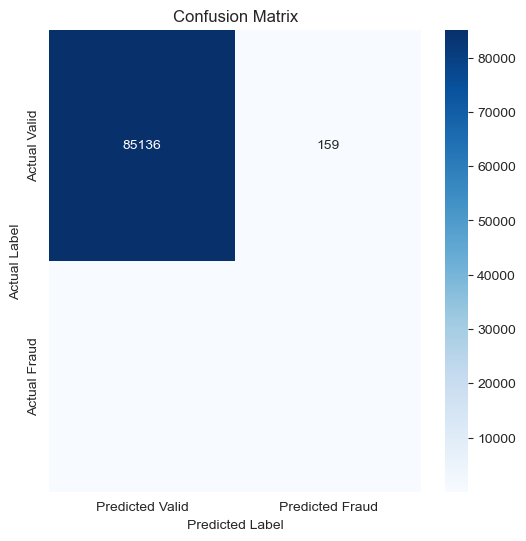


Critical Errors (False Negatives - Missed Fraud): 28
Customer Impact (False Positives - Incorrectly Flagged): 159


In [14]:
# Plot 4: Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Valid', 'Predicted Fraud'],
            yticklabels=['Actual Valid', 'Actual Fraud'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

TN = cm[0, 0] 
FP = cm[0, 1] 
FN = cm[1, 0] 
TP = cm[1, 1] 

print(f"\nCritical Errors (False Negatives - Missed Fraud): {FN}")
print(f"Customer Impact (False Positives - Incorrectly Flagged): {FP}")


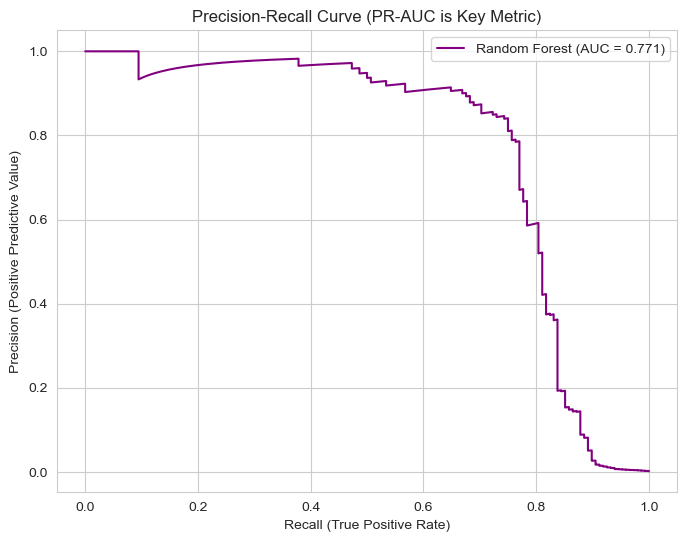

In [15]:

# Plot 5: Precision-Recall Curve (Ideal for imbalanced data)
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Random Forest (AUC = {pr_auc:.3f})', color='purple')
plt.xlabel('Recall (True Positive Rate)')
plt.ylabel('Precision (Positive Predictive Value)')
plt.title('Precision-Recall Curve (PR-AUC is Key Metric)')
plt.legend()
plt.show()


--- Feature Importance ---


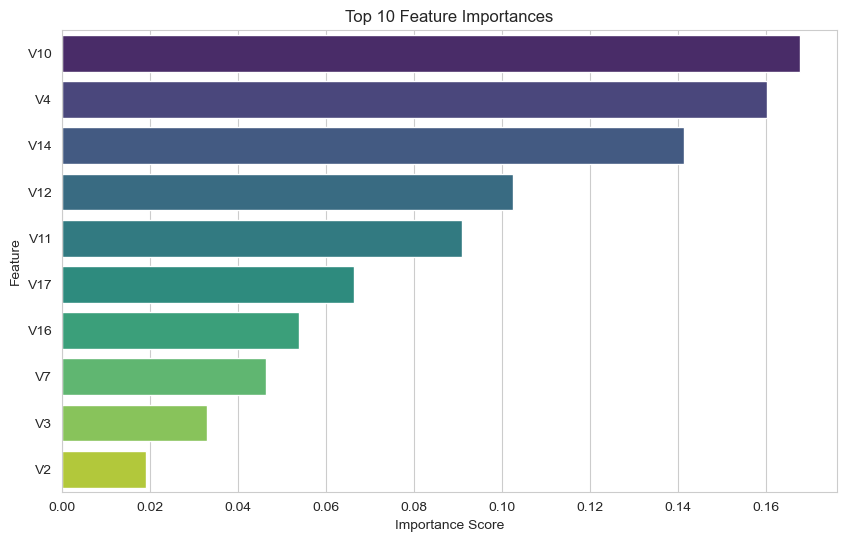

The most important features for detection (V-features) are typically the result of PCA.


In [16]:
# Random Forest allows us to see which features were most influential
print("--- Feature Importance ---")
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
top_10_features = feature_importances.nlargest(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_features.values, y=top_10_features.index, palette='viridis')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

print("The most important features for detection (V-features) are typically the result of PCA.")


In [17]:
# ### 8. Model Deployment Preparation
###

# %% [python]
# Save the trained model to a file using joblib.
# This file can then be loaded by a separate application (like a VS Code frontend/backend) 
# for real-time predictions without retraining.
model_filename = 'fraud_detection_model.joblib'
joblib.dump(model, model_filename)

print(f"Trained Random Forest model successfully saved to {model_filename}")
# To load the model later in your VS Code project:
# loaded_model = joblib.load('fraud_detection_model.joblib')

print("\n" + "-"*60 + "\n") # Cell Separator

Trained Random Forest model successfully saved to fraud_detection_model.joblib

------------------------------------------------------------



In [18]:
# ### 7.5 Displaying Individual Test Results
###

# %% [python]
# Display individual results from the test set for granular validation
results_df = X_test.copy()
results_df['Actual_Class'] = y_test
results_df['Predicted_Class'] = y_pred
results_df['Prediction_Probability'] = y_prob

print("--- Sample of Test Set Results (Including Errors) ---")
# Show a sample that includes all actual fraud cases if possible, plus a few others
fraud_results = results_df[results_df['Actual_Class'] == 1].head(10)
other_results = results_df[results_df['Actual_Class'] == 0].sample(5, random_state=42)
final_display = pd.concat([fraud_results, other_results]).sort_index()

# Display the columns most relevant for review
print(final_display[['Actual_Class', 'Predicted_Class', 'Prediction_Probability']].head(15).to_markdown(index=True))


--- Sample of Test Set Results (Including Errors) ---
|        |   Actual_Class |   Predicted_Class |   Prediction_Probability |
|-------:|---------------:|------------------:|-------------------------:|
|  11050 |              0 |                 0 |               0.126031   |
|  42549 |              1 |                 1 |               0.999646   |
|  43204 |              1 |                 1 |               0.999701   |
|  47802 |              1 |                 1 |               0.959415   |
|  92913 |              0 |                 0 |               0.00521705 |
| 124115 |              1 |                 1 |               0.963492   |
| 147558 |              0 |                 0 |               0.00147838 |
| 153823 |              1 |                 1 |               0.999654   |
| 177928 |              0 |                 0 |               0.0209234  |
| 191074 |              1 |                 0 |               0.114704   |
| 218442 |              1 |                 1 

In [19]:
# ### 8. Model Deployment Preparation
###

# %% [python]
# Calculate and display final test accuracy before saving
final_accuracy = accuracy_score(y_test, y_pred)
# UPDATED: Display final accuracy as a percentage
print(f"Final Test Accuracy: {final_accuracy * 100:.2f}%")


Final Test Accuracy: 99.78%
